# Matching techniques for finding correspondences between descriptors

We want to find a correspondence between keypoints in detection and tracking tasks, but we can't compare the points themselves; instead, we should deal with keypoints descriptors. Keypoints descriptors were especially developed to make it possible to compare them. This recipe shows you OpenCV's approaches to comparing the descriptors and building up the correspondence between them using various matching techniques.

OpenCV supports a lot of different matching types. All of them are implemented using the `cv2.DescriptorMatcher` interface, so any type of matcher supports the same methods and the same scenarios of use. There are two types of matcher usage: detecting mode and tracking mode. Technically, there is not a big difference between these two modes because in both cases, we need to have two sets of descriptors to match them. The question is whether we upload the first set once and compare it with another one, or each time pass two descriptor sets to the match function. To upload the descriptor set, you need to use the `cv2.DescriptorMatcher.add` function, which just accepts a list of your descriptors. After you've finished adding the descriptors, in some cases, you need to call the `cv2.DescriptorMatcher.train` method to tell the matcher handle about the descriptors and prepare them for the matching process.

`cv2.DescriptorMatcher` has several methods to perform matching, and all of these methods have overloads for detecting and tracking modes. `cv2.DescriptorMatcher.match` is used to get the single best correspondence between descriptors. `cv2.DescriptorMatcher.knnMatch` and `cv2.DescriptorMatcher.radiusMatch` ret urn several of the best correspondences between descriptors.

The simplest and most obvious approach to find the best descriptor matches is to just compare all possible pairs and choose the best. Needless to say, this method is extremely slow. But if you decide to use it (for example, as a reference), you need to call the `cv2.BFMatcher_create` function. It takes a type of distance metric for descriptor comparison and enables the cross-checking flag.

To create smarter and faster matchers, you need to call `cv2.FlannBasedMatcher`. By default, it creates KD-tree indexing with default parameters. To create other types of matchers and set up their parameters, you need to pass two dictionaries for the `cv2.FlannBasedMatcher` function. First, the dictionary describes the algorithm for indexing descriptors and its parameters. The second argument describes the process of searching for the best match.

In [1]:

# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep  = pYstep  = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    #print("pXstep", pXstep, "pYstep", pYstep)
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S07\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s07\env

d:\html_doc\program\opencv\packt\s07\env\lib\site-packages
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S07\env


In [2]:
def video_keypoints(matcher, image_frames, cap=None, 
                    detector=cv2.ORB_create(40)):
    cap = cap if cap != None else cv2.VideoCapture("../data/traffic.mp4")
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    c = 0
    while True:
        status_cap, frame = cap.read()
        if not status_cap:
            break
        frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)
        if (cap.get(cv2.CAP_PROP_POS_FRAMES) - 1) % 40 == 0:
            key_frame = np.copy(frame)
            key_points_1, descriptors_1 = detector.detectAndCompute(frame, None)
        else:
            key_points_2, descriptors_2 = detector.detectAndCompute(frame, None)
            matches = matcher.match(descriptors_2, descriptors_1)
            frame = cv2.drawMatches(frame, key_points_2, 
                                    key_frame, key_points_1, 
                                    matches, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS | 
                                    cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
        
        c += 1
        if c % 250 == 0 or c ==1:
             image_frames.append(["frame:{0}".format(c),frame[:,:,[2,1,0]]])
        cv2.imshow('Keypoints matching', frame)
        key = cv2.waitKey(1)
        if key == 27:
            break
        #if cv2.waitKey(300) == 27: break

    cv2.destroyAllWindows()

In [3]:
capture = cv2.VideoCapture('../data/traffic.mp4')

print(capture.isOpened())
print('Created capture:', '../data/shuttle.mp4')
print('Frame count:', int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Frame width:', int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height:', int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame rate:', capture.get(cv2.CAP_PROP_FPS))



bf_matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, True)
image_frames = []
video_keypoints(bf_matcher, image_frames,capture)

True
Created capture: ../data/shuttle.mp4
Frame count: 1501
Frame width: 1920
Frame height: 1080
Frame rate: 25.0


len(res10_300x300_ssd_iter_140000) == 7
0 0


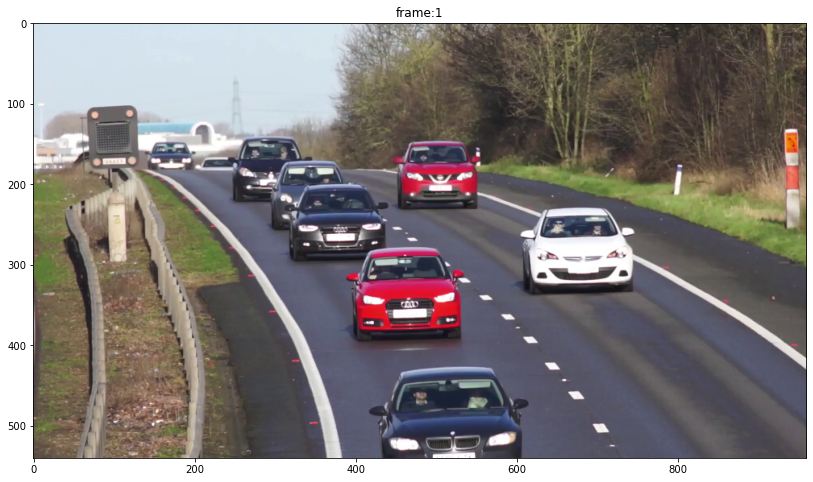

1 1


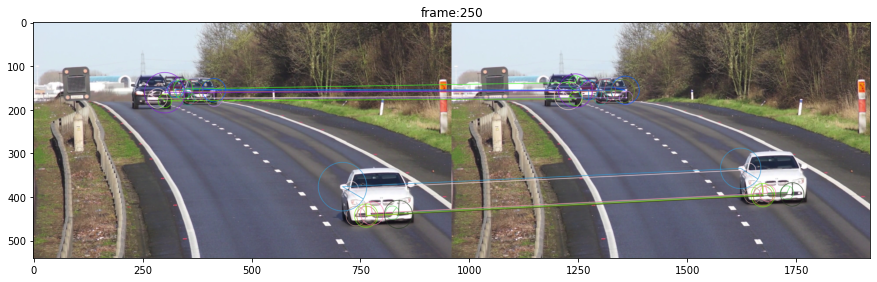

2 2


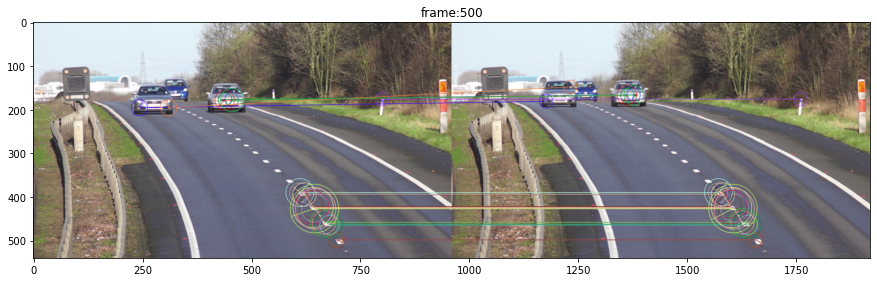

3 3


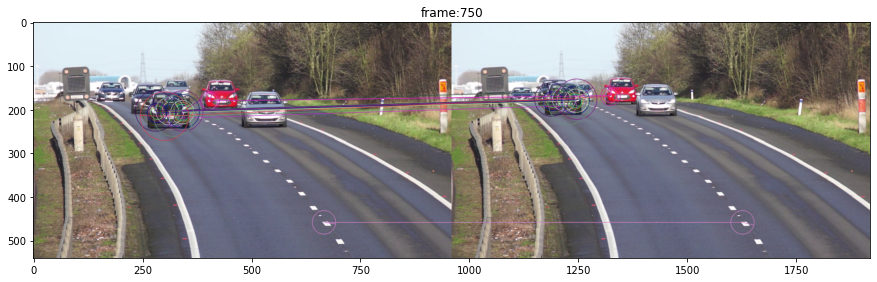

4 4


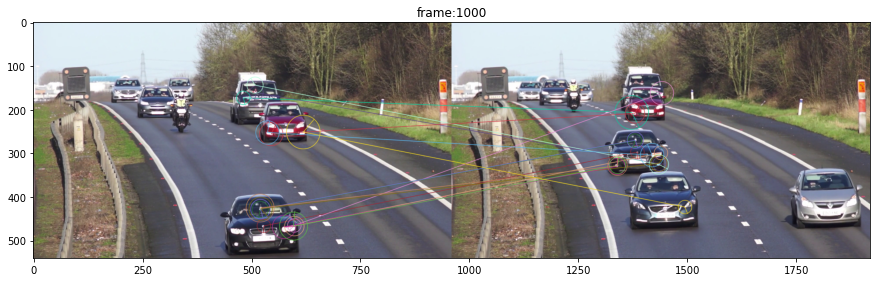

5 5


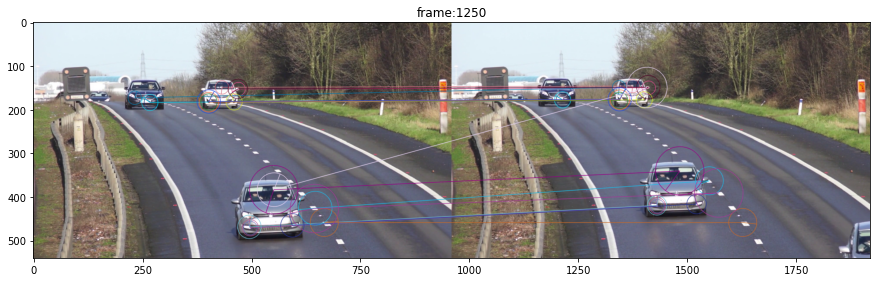

6 6


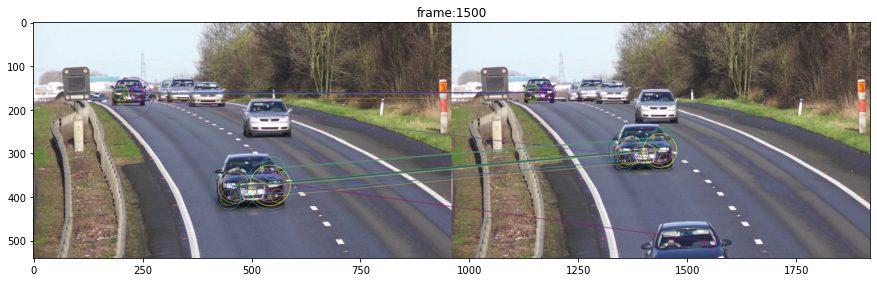

In [4]:
print("len(res10_300x300_ssd_iter_140000) ==", len(image_frames))
k =1
for i in range(0,len(image_frames),k):
    print(i,i+k-1)
    plt_view_image(plt,image_frames[i:i+k], figsize=(15,8), axis='on', cmap='gray')

len(res10_300x300_ssd_iter_140000) == 7
0 0


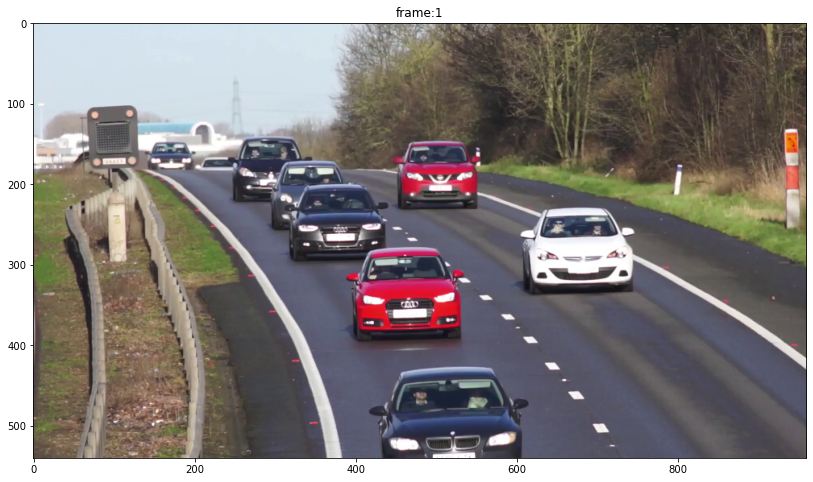

1 1


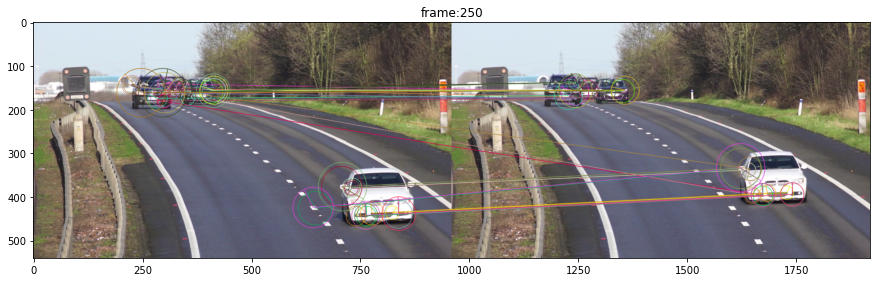

2 2


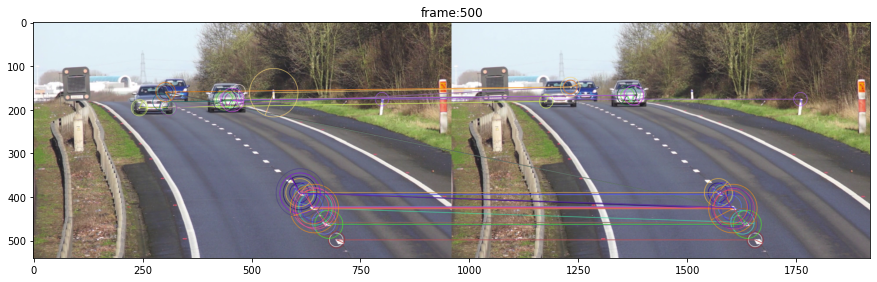

3 3


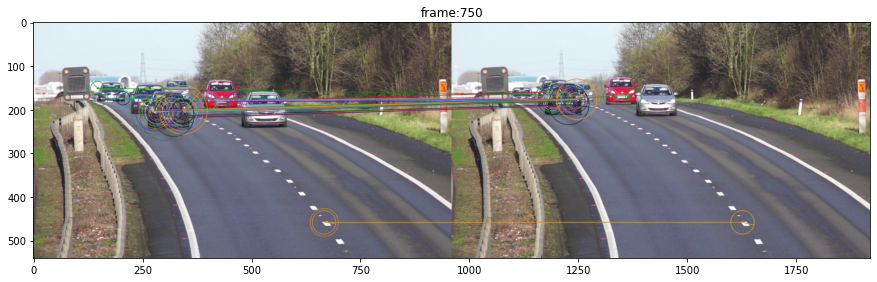

4 4


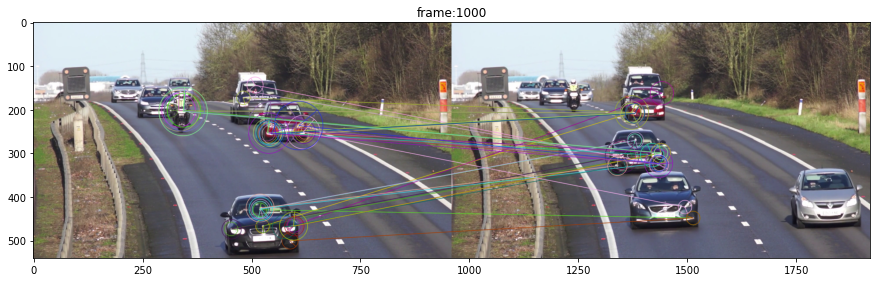

5 5


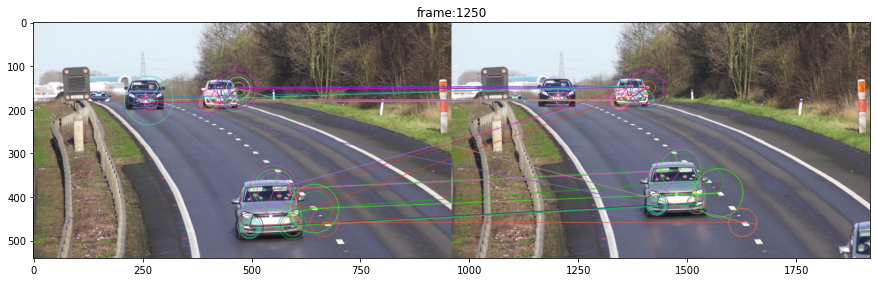

6 6


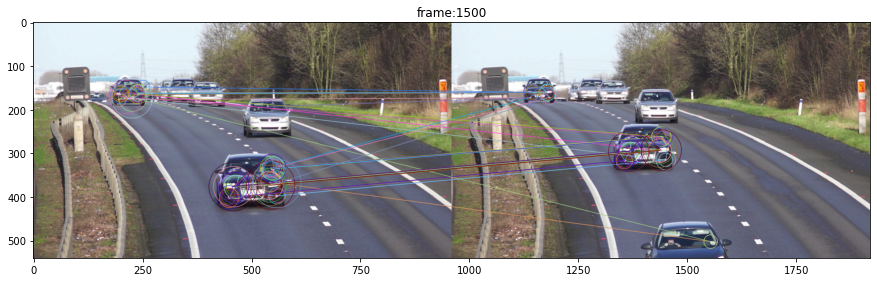

In [5]:
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=20, key_size=15, multi_probe_level=2)
search_params = dict(checks=10)


flann_kd_matcher = cv2.FlannBasedMatcher(index_params, search_params)
image_frames = []
video_keypoints(flann_kd_matcher, image_frames,None)




#########################################################
print("len(res10_300x300_ssd_iter_140000) ==", len(image_frames))
k =1
for i in range(0,len(image_frames),k):
    print(i,i+k-1)
    plt_view_image(plt,image_frames[i:i+k], figsize=(15,8), axis='on', cmap='gray')

In [6]:
FLANN_INDEX_COMPOSITE = 3
index_params = dict(algorithm=FLANN_INDEX_COMPOSITE, trees=16)
search_params = dict(checks=10)


flann_kd_matcher = cv2.FlannBasedMatcher(index_params, search_params)
image_frames = []
video_keypoints(flann_kd_matcher,image_frames,None, detector=cv2.xfeatures2d.SURF_create(20000))




#########################################################
print("len(res10_300x300_ssd_iter_140000) ==", len(image_frames))
k =1
for i in range(0,len(image_frames),k):
    print(i,i+k-1)
    plt_view_image(plt,image_frames[i:i+k], figsize=(15,8), axis='on', cmap='gray')

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


In [ ]:
capture = cv2.VideoCapture('../data/traffic.mp4')

print(capture.isOpened())
print('Created capture:', '../data/shuttle.mp4')
print('Frame count:', int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Frame width:', int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height:', int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame rate:', capture.get(cv2.CAP_PROP_FPS))


flann_kd_matcher = cv2.FlannBasedMatcher()
image_frames = []
video_keypoints(flann_kd_matcher, image_frames,capture,detector=cv2.xfeatures2d.SURF_create(20000))